# Analysis of Flows Generated by nProbe
Fields explanation: 
- https://www.ntop.org/guides/nprobe/cli_options.html

Our chosen fields:
- https://docs.google.com/document/d/1iUGJCUTnNwWWoc9eHqPm-s5-3ZF1-qcsVbuNOSYVld0

## Analysis Conclusions

- **Drop**
   - `BIFLOW_DIRECTION`
      - All values are the same (0)
      - Flow direction can be determined according to `DIRECTION` feature
- **Think about removal**
   - `INPUT_SNMP`, `OUTPUT_SNMP`
      - This information is not that valuable, as input/output SNMP interface is not always correlated with the `DIRECTION` field (see experiments below)  
   - `FORWARDING_STATUS`
      - All values are the same (0 == unknown forwarding status)
      - Based on the [Cisco NetFlow page](https://www.cisco.com/en/US/technologies/tk648/tk362/technologies_white_paper09186a00800a3db9.html), we probably couldn't utilize value for intrusion detection anyway as it is discussing forwarding status of a flow
   - `TLS_VERSION`
      - All values are the same (0) 
      - Seems like nProbe is unable to determine TLS version due to 80B packet trimming -- TLS header is trimmed and thus nProbe probably ignores it whole
   - `NUM_PKTS_TTL_...`
      - It seems nProbe only computes TTL of inbound packets (thus in one direction)
      - Also, TTLs are interestingly low during in the whole dataset
   - `L7_PROTO_RISK`, `L7_PROTO_RISK_NAME`, `L7_RISK_SCORE`
      - Since we are trimming packets to 80B, it is questionable how useful will this feature be.
      - However, fields seems to provide relative nice insights into the traffic - like purely unidirectional traffic, known protocol on different port etc.
      - It is questionable how would we use it and it takes too many place to keep RISK names and again, I wasn't able to find any table that would translate numbers to text online... 
   - `L7_ERROR_CODE`
      - Another potentially interesting feture, but again, we don't know what do codes mean
      - Also, the space is very sparse as based on our sample, almost 98% flows contained no error
      - Seeing what do codes mean and if they relate to atacks would be interesting
      - But again, can we rely on L7 feature while trimming payloads? 
- **Keep in dataset but don't use**
   - `APPLICATION_ID`
      - Applications are in the form of codes, so encoding (such as one-hot), causing dimensionality explosion would be needed
      - We somehow do application recognization by port binning
      - Also, I was not able to find mapping of application IDs to their names nowhere...
      - IF we were able to find the mapping, it would be useful to keep, otherwise probably delete
- **Notes and ovservations**
   - `FLOW_END_REASON`
      - Flow timeout needs to be heavily increased - not a single flow was ended normally, all timed out...
      - As I mentioned before, our timers are veeeeery low and this capture proves it, although it is strange not a single flow was ended properly and all timed out...
      - This would need further investigation
   - `DIRECTION`, `IN_PKTS`, `OUT_PKTS`, `CLIENT_TCP_FLAGS`, `SERVER_TCP_FLAGS`
      - All these features relate to direction of the flow 
      - It would need a deeper understanding of _HOW_ nProbe creates flows
      - Accoding to my empirical observation:
         - Packets from the initiator (client) are in `IN_PKTS` feature and its flags in `CLIENT_TCP_FLAGS`
         - Packets from the responder (server) are in `OUT_PKTS` feature and its flags in `SERVER_TCP_FLAGS` 
         - `SYN` always marks client and thus an inbound data
         - If no `SYN` is captured in the flow, the client (source) is considered an entity with first captured packet in the flow
         - Are there any advanced heuristics? Like catching `SYN-ACK` response would mark a server etc.
         - Would need a deeper dive...
   - `NUM_PKTS_UP_TO_128_BYTES`
      - This feature was not included in the config and thus not computed
      - Theoretically, we can compute it by all other features, but I would include it for the sake of completeness
      - It is estimated that 70% of flows contain only 128B or less according to our analysis
   - `IPV6_SRC_ADDR` vs. `IPV4_SRC_ADDR`
      - If the flow is IPv4, IPv6 fields contain `::` value
      - If the flow is IPv6, IPv4 fields contain `0.0.0.0` value
      - Determining whether the flow is IPv4 or IPv6 -> check if IPv6 field is `::` or not  

## Analysis Details

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [ ]:
FILENAME = '20220726_232604.flows'

In [ ]:
flows = pd.read_csv(FILENAME, sep='|', header='infer')

In [ ]:
flows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 77 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   IN_BYTES                     10000 non-null  int64 
 1   IN_PKTS                      10000 non-null  int64 
 2   PROTOCOL                     10000 non-null  int64 
 3   TCP_FLAGS                    10000 non-null  int64 
 4   L4_SRC_PORT                  10000 non-null  int64 
 5   IPV4_SRC_ADDR                10000 non-null  object
 6   INPUT_SNMP                   10000 non-null  int64 
 7   L4_DST_PORT                  10000 non-null  int64 
 8   IPV4_DST_ADDR                10000 non-null  object
 9   OUTPUT_SNMP                  10000 non-null  int64 
 10  OUT_BYTES                    10000 non-null  int64 
 11  OUT_PKTS                     10000 non-null  int64 
 12  MIN_IP_PKT_LEN               10000 non-null  int64 
 13  MAX_IP_PKT_LEN               100

In [ ]:
flows.head()

## Intriguing Columns Investigation
Consider for dumping after analysis:
- [x] Relationship between: `INPUT_SNMP`, `OUTPUT_SNMP`, `DIRECTION`, and `BIFLOW_DIRECTION`
- [x] Relationship between: `FLOW_START_MILLISECONDS`, `FLOW_END_MILLISECONDS` vs. `DURATION_IN`, `DURATION_OUT`
   - Let's pretend nProbe extract these features well without additional verification
   - Although, deciding what is client and server is still an interesting problem
- [x] Values, distribution: `FORWARDING_STATUS`
- [x] Values, distribution: `APPLICATION_ID`
- [x] Values, distribution: `FLOW_END_REASON`
- [x] Values, distribution: `TLS_VERSION`
- [x] Values, distribution: `L7_PROTO_RISK`, `L7_PROTO_RISK_NAME`, `L7_RISK_SCORE`,
- [x] Values, distribution: `FLOW_VERDICT`
- [x] Values, distribution: `L7_ERROR_CODE`

To better understand the data, getting values and distribution would be interesting, but especially for:
- [x] Relationship between IPv4 and IPv6 address field - values when IPv4/IPv6 flow is present
- [x] Format analysis:      `FLOW_START_MILLISECONDS`, `FLOW_END_MILLISECONDS`
- [x] Format of TCP flags `CLIENT_TCP_FLAGS`, `SERVER_TCP_FLAGS`
- [x] Relationship beween `CLIENT_TCP_FLAGS`, `SERVER_TCP_FLAGS` and `IN_PKTS`, `OUT_PKTS`
- [x] Other interesting:
   - `SRC_FRAGMENTS`, `DST_FRAGMENTS`
   - `SRC_TO_DST_AVG_THROUGHPUT`, `DST_TO_SRC_AVG_THROUGHPUT`
   - `NUM_PKTS_128_TO_256_BYTES` ... `NUM_PKTS_OVER_1514_BYTES`

Features not investigated in this analysis:
- The first 16 basic features with except to IN_PKTS and OUT_PKTS
- Longest and shortest flow packet - I believe they work as intented
- Deep analysis of retransmitted and out-of-order packets
- TCP windows features
- flow inter-packet arrival time features

### Investigate NULL values

In [ ]:
flows.columns[flows.isna().any()].tolist()

['L7_PROTO_RISK_NAME']

In [ ]:
# Determine the number NULL rows for L7_PROTO_RISK_NAME field
flows['L7_PROTO_RISK_NAME'].isna().sum()

5555

### Low-Variance Values Investigation

In [ ]:
def determine_low_variance_features(data: pd.DataFrame, max_uniq_ftrs: int = 10):
    """Determines the number of unique features in particular columns"""

    for uniq_ftrs in range(1, max_uniq_ftrs+1):
        ftrs_list = list(data.columns[data.nunique() == uniq_ftrs])

        print("Columns with {} unique feature(s):".format(uniq_ftrs))

        for feature in ftrs_list:
            print("{:25}: {}".format(feature, dict(data[feature].value_counts())))

        print()

In [ ]:
determine_low_variance_features(flows)

Columns with 1 unique feature(s):
FORWARDING_STATUS        : {0: 10000}
FLOW_END_REASON          : {'idle_timeout': 10000}
BIFLOW_DIRECTION         : {1: 10000}
NUM_PKTS_TTL_160_192     : {0: 10000}
TLS_VERSION              : {0: 10000}
FLOW_VERDICT             : {0: 10000}

Columns with 2 unique feature(s):
DIRECTION                : {0: 7849, 1: 2151}
SRC_FRAGMENTS            : {0: 9299, 1: 701}
OOORDER_IN_PKTS          : {0: 9994, 1: 6}
NUM_PKTS_TTL_EQ_1        : {0: 9995, 1: 5}
NUM_PKTS_TTL_5_32        : {0: 9995, 1: 5}
NUM_PKTS_TTL_128_160     : {0: 9999, 1: 1}

Columns with 3 unique feature(s):
NUM_PKTS_TTL_2_5         : {0: 9995, 1: 4, 2: 1}

Columns with 4 unique feature(s):
DST_FRAGMENTS            : {0: 9991, 3: 4, 4: 4, 2: 1}
NUM_PKTS_OVER_1514_BYTES : {0: 9991, 3: 4, 4: 4, 2: 1}
RETRANSMITTED_OUT_PKTS   : {0: 9981, 1: 16, 2: 2, 31: 1}
NUM_PKTS_TTL_192_224     : {0: 9973, 1: 24, 2: 2, 4: 1}

Columns with 5 unique feature(s):
OOORDER_OUT_PKTS         : {0: 9981, 1: 13, 2: 3, 

### Number of Packets Within Flows

In [ ]:
# Get number a proportion of single packets flows
(flows['IN_PKTS'] + flows['OUT_PKTS'] == 1).sum() / len(flows)

0.4745

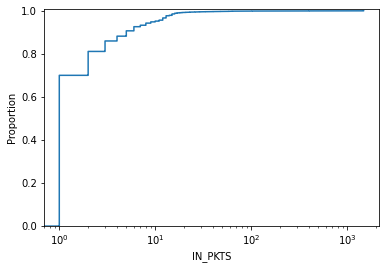

In [ ]:
# Get ECDFs for IN and OUT_PKTS values
ax = sns.ecdfplot(flows, x='IN_PKTS', log_scale=True)
ax.set_ylim(0, 1.01)
plt.show()


/home/goldy/.local/share/virtualenvs/vnet-fzuaHEfK/lib64/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


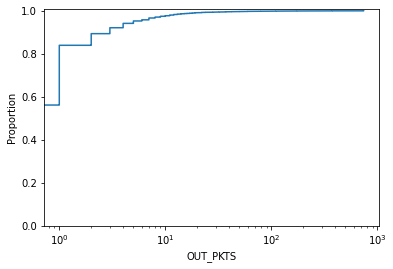

In [ ]:
# Get ECDFs for IN and OUT_PKTS values
ax = sns.ecdfplot(flows, x='OUT_PKTS', log_scale=True)
ax.set_ylim(0, 1.01)
plt.show()


In [ ]:
# Hmmm, are there no 0- IN_PACKETS flows but so many of 0-OUT packets?
len(flows[flows['IN_PKTS'] == 0])

0

In [ ]:
len(flows[flows['OUT_PKTS'] == 0])

5622

Ok, the flow is apparently created by the first packet nProbe sees, it would be interesting to see if the first packet is always really the packet which initiated the session (such as TCP SYN... let's investigate)

### Relationship between IN_PKTS / OUT_PKTS and CLIENT/SERVER TCP flags

In [ ]:
# Get the proportion of single-packet flows
len(flows[(flows['IN_PKTS'] == 1) & (flows['OUT_PKTS'] == 0)])

4745

In [ ]:
# Client flags when there are no OUT packets
flows[flows['OUT_PKTS'] == 0]['CLIENT_TCP_FLAGS'].value_counts()

0      2666
2      1455
25      642
16      271
17      178
20      128
18       87
24       80
4        49
6        24
194      16
27       14
28        5
91        3
26        2
29        1
21        1
Name: CLIENT_TCP_FLAGS, dtype: int64

In [ ]:
# Server flags when there are no OUT packets
flows[flows['OUT_PKTS'] == 0]['SERVER_TCP_FLAGS'].value_counts()

0    5622
Name: SERVER_TCP_FLAGS, dtype: int64

Based on these findings, we can conclude that SERVER activity is associated only with connection OUT packets. Therefore, nProbe bases source of the flow based on TCP flags it sees. If the protocol is not TCP, the first seen packet (like UDP or ICMP) is considered as a source (client) of the flow. It would be most interesting to see how would this behave with sampling, as some SYNs will be most certainly lost.

### Relationship Between Interfaces and Directions

In [ ]:
flows['INPUT_SNMP'].value_counts()

21267    3854
60097    2850
17475    1737
49473     915
33985     349
25089     293
6935        1
11373       1
Name: INPUT_SNMP, dtype: int64

In [ ]:
flows['OUTPUT_SNMP'].value_counts()

21267    3159
60097    2819
49473    1407
17475    1247
33985    1031
25089     334
5           3
Name: OUTPUT_SNMP, dtype: int64

In [ ]:
flows['DIRECTION'].value_counts()

0    7849
1    2151
Name: DIRECTION, dtype: int64

In [ ]:
flows['BIFLOW_DIRECTION'].value_counts()

1    10000
Name: BIFLOW_DIRECTION, dtype: int64

SNMP interfaces are marked by their index. Let's investigate relationship between SNMP interface ID and the `DIRECTION` and `BIFLOW_DIRECTION` fields. As apparent, BIFLOW_DIRECTION is always set to "1" (initiator), so the this feature collection is obviously not working correctly or is meant for a different purpose (like when nprobe is run). Let's see how SNMP interface relates to `DIRECTION`:

In [ ]:
flows[flows['DIRECTION'] == 0]['INPUT_SNMP'].value_counts()

21267    3821
60097    1893
17475    1693
49473     262
33985      91
25089      87
6935        1
11373       1
Name: INPUT_SNMP, dtype: int64

In [ ]:
flows[flows['DIRECTION'] == 1]['INPUT_SNMP'].value_counts()

60097    957
49473    653
33985    258
25089    206
17475     44
21267     33
Name: INPUT_SNMP, dtype: int64

In [ ]:
flows[flows['DIRECTION'] == 0]['OUTPUT_SNMP'].value_counts()

60097    2787
21267    1976
49473    1364
33985    1030
17475     356
25089     333
5           3
Name: OUTPUT_SNMP, dtype: int64

In [ ]:
flows[flows['DIRECTION'] == 1]['OUTPUT_SNMP'].value_counts()

21267    1183
17475     891
49473      43
60097      32
33985       1
25089       1
Name: OUTPUT_SNMP, dtype: int64

As we might see, there is no clear connection between input/output SNMP interface as both interfaces are present in both 0 and 1 directions... This would need a topology for futher investigation...

### IPv4/IPv6 Addresses Fields Relationships

In [ ]:
flows['IPV6_SRC_ADDR'].value_counts().head(5)

::                                  9893
2a01:390:1:e:355d:9c11:891c:f1a8      31
2a01:390:1:e:8cea:bf25:11bd:4fe3      14
2a01:390:1:e:2dae:9c56:60df:d43f       9
2a05:980::10                           8
Name: IPV6_SRC_ADDR, dtype: int64

In [ ]:
flows['IPV6_DST_ADDR'].value_counts().head(5)

::                          9893
2a01:390:dc4:a::e             10
2a00:1450:4014:80a::200e      10
2a00:1450:4014:80b::200e       8
2a01:390:dc4:a::d              7
Name: IPV6_DST_ADDR, dtype: int64

Ok, it seems that when the packet is IPv4, IPv6 address is given as `::`. How do IPv4 look like  when address is not `::`?

In [ ]:
flows[flows['IPV6_DST_ADDR'] != '::']['IPV4_DST_ADDR'].value_counts()

0.0.0.0    107
Name: IPV4_DST_ADDR, dtype: int64

Seems like IPv4 addresses are given as 0.0.0.0.

Determining whether the packet is IPv4 or IPv6 - IPv6 is not `::`

### Flow Timestamps Analysis

In [ ]:
flows['FLOW_START_MILLISECONDS'].head()

0    1658877961005
1    1658877961005
2    1658877961005
3    1658877961005
4    1658877961005
Name: FLOW_START_MILLISECONDS, dtype: int64

In [ ]:
flows['FLOW_END_MILLISECONDS'].head()

0    1658877961005
1    1658877961005
2    1658877961005
3    1658877961005
4    1658877961005
Name: FLOW_END_MILLISECONDS, dtype: int64

These are regular ms timestamps as declared. Parsing and working it with will be easy and straightforward.

In [ ]:
# Let's create new column in order to compare with DURATION_IN and DURATION_OUT fields
flows['FLOW_DURATION'] = flows['FLOW_END_MILLISECONDS'] - flows['FLOW_START_MILLISECONDS']

<AxesSubplot:xlabel='FLOW_DURATION', ylabel='Proportion'>

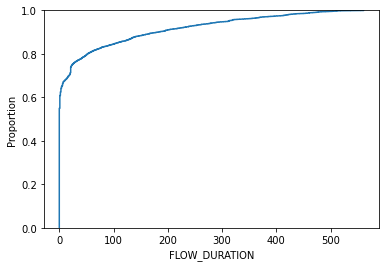

In [ ]:
# Plot ECDF plot to better see durations
sns.ecdfplot(flows, x='FLOW_DURATION')

In [ ]:
# Determine if flow durations in contrast to IN_DURATION and OUT_DURATION columns
flows['FLOW_DURATION'] - flows['DURATION_IN']

0       0
1       0
2       0
3       0
4       0
       ..
9995    1
9996    0
9997    0
9998    0
9999    0
Length: 10000, dtype: int64

### TCP Flags Format

In [ ]:
flows['CLIENT_TCP_FLAGS'].value_counts()

0      4066
2      1657
24     1228
25      975
16      547
17      368
22      227
27      189
20      130
18      124
30       85
6        78
29       63
26       51
4        50
28       39
219      36
31       24
194      16
21       14
19       13
218      10
222       4
91        3
223       2
23        1
Name: CLIENT_TCP_FLAGS, dtype: int64

In [ ]:
flows['SERVER_TCP_FLAGS'].value_counts()

0     7022
16     983
24     580
18     329
20     273
27     183
17     141
25     123
4       81
31      81
26      62
28      45
91      33
29      26
21       8
19       8
86       5
22       4
23       4
90       4
30       3
2        1
87       1
Name: SERVER_TCP_FLAGS, dtype: int64

nProbe documentation declares that flags are cumulatives. In this way, they probably meant XORs. It would be interesting to determine how is the server/client determined. As we might see, SERVER flags is determined with SYN only once, whereas CLIENT got 1657 pure SYNs connections.

### FORWARDING_STATUS Values and Distribution

In [ ]:
flows['FORWARDING_STATUS'].value_counts()

0    10000
Name: FORWARDING_STATUS, dtype: int64

### APPLICATION_ID Values and Distribution

In [ ]:
flows['APPLICATION_ID'].value_counts()

369098752    4566
369098759     924
369098843     821
369098773     582
369098833     555
             ... 
369098800       1
369098955       1
369098810       1
369098839       1
369098968       1
Name: APPLICATION_ID, Length: 97, dtype: int64

In [ ]:
# Are there cases when no application was recognized?
len(flows[flows['APPLICATION_ID'] == 0])

0

OK seems interesting, but how not decipher what those numbers mean... Cisco was supposed to keep some application ID registry, but I don't seem to be able to find it...

### FLOW_END_REASON Values and Distribution

In [ ]:
flows['FLOW_END_REASON'].value_counts()

idle_timeout    10000
Name: FLOW_END_REASON, dtype: int64

All flows seem to end due to idle_timeout. This demonstrates that the currently set flow timeout is **hellishly** small.

### TLS_VERSION Values and Distribution

In [ ]:
flows['TLS_VERSION'].value_counts()

0    10000
Name: TLS_VERSION, dtype: int64

There does not seem to be a lot of information... Either no TLS handshake was performed or the 80B snaplen is too small to derive TLS version. Accroding to TLS packet structure (https://miro.medium.com/max/1400/1*2eTgsAvVGl3uz3H0VufQGA.png), TLS version should be visible to nProbe. However, TLS header is always cut short, so nProbe probably skips it due to being trimmed.

### L7_PROTO Values and Distribution

In [ ]:
flows['L7_PROTO_RISK'].value_counts()

0                 5555
70368744177664    3652
4194304            193
70368748371968     158
70368744308736     128
79164837199872     107
8796093022208       87
32                  60
1073741824          28
70369817919488      18
131072               3
1073741856           3
65536                2
8796093022240        1
8796093153312        1
17179869184          1
68723671040          1
70385924046848       1
4194336              1
Name: L7_PROTO_RISK, dtype: int64

In [ ]:
flows['L7_PROTO_RISK_NAME'].value_counts()

Unidirectional Traffic                                     3652
Unsafe Protocol                                             193
Unsafe Protocol,Unidirectional Traffic                      158
Malformed Packet,Unidirectional Traffic                     128
Error Code,Unidirectional Traffic                           107
Error Code                                                   87
Known Proto on Non Std Port                                  60
Desktop/File Sharing                                         28
Desktop/File Sharing,Unidirectional Traffic                  18
Known Proto on Non Std Port,Desktop/File Sharing              3
Malformed Packet                                              3
Suspicious DGA Domain name                                    2
TLS Fatal Alert                                               1
Known Proto on Non Std Port,Malformed Packet,Error Code       1
Unsafe Protocol,Clear-Text Credentials                        1
TLS Fatal Alert,Unidirectional Traffic  

In [ ]:
flows['L7_RISK_SCORE'].value_counts()

0      5555
10     3964
20      412
50       60
60        5
100       2
70        1
110       1
Name: L7_RISK_SCORE, dtype: int64

These are actually interesting, but state space seems rather big, so mapping them to the descriptions and risk scores seems challenging. Let's filter some rows with the biggest risk. Is there any documentation for it?

In [ ]:
flows[flows['L7_RISK_SCORE'] >= 70][['L7_RISK_SCORE', 'L7_PROTO_RISK', 'L7_PROTO_RISK_NAME']]

,L7_RISK_SCORE,L7_PROTO_RISK,L7_PROTO_RISK_NAME
1265,70,8796093153312,"Known Proto on Non Std Port,Malformed Packet,E..."
2353,100,65536,Suspicious DGA Domain name
3934,100,65536,Suspicious DGA Domain name
4292,110,68723671040,"Unsafe Protocol,Clear-Text Credentials"


### FLOW_VERDICT Values and Distribution

In [ ]:
flows['FLOW_VERDICT'].value_counts()

0    10000
Name: FLOW_VERDICT, dtype: int64

Any documentation for this?

### L7_ERROR_CODE Values and Distribution

In [ ]:
flows['L7_ERROR_CODE'].value_counts()

0      9783
400     189
200      19
429       3
404       2
503       1
15        1
301       1
5         1
Name: L7_ERROR_CODE, dtype: int64

Again, documentation would be nice. Are these 400 HTTP errors? How they are obtained when we trim to 80B and data are encrypted?

### SRC_FRAGMENTS DST_FRAGMENTS Values and Distribution

In [ ]:
flows['SRC_FRAGMENTS'].value_counts()

0    9299
1     701
Name: SRC_FRAGMENTS, dtype: int64

In [ ]:
flows['DST_FRAGMENTS'].value_counts()

0    9991
3       4
4       4
2       1
Name: DST_FRAGMENTS, dtype: int64

### SRC_TO_DST_AVG_THROUGHPUT and DST_TO_SRC_THROUGHPUT
Throughput in bps (bit per second)

In [ ]:
flows['SRC_TO_DST_AVG_THROUGHPUT']

0        688000
1       1016000
2        416000
3        416000
4        912000
         ...   
9995    1382211
9996     352000
9997     352000
9998    1392000
9999     480000
Name: SRC_TO_DST_AVG_THROUGHPUT, Length: 10000, dtype: int64

In [ ]:
flows['SRC_TO_DST_AVG_THROUGHPUT'].describe()

count    1.000000e+04
mean     7.459078e+05
std      1.107731e+07
min      1.012000e+03
25%      5.713000e+04
50%      3.200000e+05
75%      5.209365e+05
max      1.069821e+09
Name: SRC_TO_DST_AVG_THROUGHPUT, dtype: float64

### Packets Byte Ranges
By summing all flows in all categories, we could get packet size distribution for each dataset.
By selecting the column with max value, we can draw a distribution graph.

In [ ]:
interesting_cols = ['NUM_PKTS_128_TO_256_BYTES', 'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES', 'NUM_PKTS_1024_TO_1514_BYTES',
    'NUM_PKTS_OVER_1514_BYTES']

In [ ]:
flows[interesting_cols].idxmax(axis=1)

0         NUM_PKTS_128_TO_256_BYTES
1         NUM_PKTS_128_TO_256_BYTES
2         NUM_PKTS_128_TO_256_BYTES
3         NUM_PKTS_128_TO_256_BYTES
4         NUM_PKTS_128_TO_256_BYTES
                   ...             
9995    NUM_PKTS_1024_TO_1514_BYTES
9996      NUM_PKTS_128_TO_256_BYTES
9997      NUM_PKTS_128_TO_256_BYTES
9998      NUM_PKTS_128_TO_256_BYTES
9999      NUM_PKTS_128_TO_256_BYTES
Length: 10000, dtype: object

In [ ]:
flows[['IN_PKTS', 'OUT_PKTS'] + interesting_cols].head()

,IN_PKTS,OUT_PKTS,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,NUM_PKTS_OVER_1514_BYTES
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


Why are there all 0s if some packets were produced within the flow? Are only Out packets counted?

In [ ]:
flows[flows['OUT_PKTS'] > 0][['IN_PKTS', 'OUT_PKTS'] + interesting_cols]

,IN_PKTS,OUT_PKTS,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,NUM_PKTS_OVER_1514_BYTES
5,2,1,0,0,0,0,0
10,1,1,0,0,0,0,0
12,1,1,0,0,0,0,0
15,1,1,0,0,0,0,0
36,2,1,0,0,0,0,0
...,...,...,...,...,...,...,...
9988,1,1,0,0,0,0,0
9990,8,8,0,0,0,0,0
9991,2,1,0,0,0,0,0
9993,1,1,0,0,0,0,0


Seems like packet sizes are also not marked when OUT_PKTS are here... How many of such rows with all 0s sizes are here in total?

In [ ]:
len(flows[(flows['NUM_PKTS_128_TO_256_BYTES'] == 0) & (flows['NUM_PKTS_256_TO_512_BYTES'] == 0) & (flows['NUM_PKTS_512_TO_1024_BYTES'] == 0) &
    (flows['NUM_PKTS_1024_TO_1514_BYTES'] == 0) & (flows['NUM_PKTS_OVER_1514_BYTES'] == 0)]) / len(flows)

0.6965

That's a hellish high number of flows, making these features rather useless...

### Will something similar happen With TTL entries

In [ ]:
interesting_cols = ['NUM_PKTS_TTL_EQ_1', 'NUM_PKTS_TTL_2_5', 'NUM_PKTS_TTL_5_32', 'NUM_PKTS_TTL_32_64',
    'NUM_PKTS_TTL_64_96', 'NUM_PKTS_TTL_96_128', 'NUM_PKTS_TTL_128_160', 'NUM_PKTS_TTL_160_192',
    'NUM_PKTS_TTL_192_224', 'NUM_PKTS_TTL_224_255']

In [ ]:
flows[['IN_PKTS', 'OUT_PKTS'] + interesting_cols]

,IN_PKTS,OUT_PKTS,NUM_PKTS_TTL_EQ_1,NUM_PKTS_TTL_2_5,NUM_PKTS_TTL_5_32,NUM_PKTS_TTL_32_64,NUM_PKTS_TTL_64_96,NUM_PKTS_TTL_96_128,NUM_PKTS_TTL_128_160,NUM_PKTS_TTL_160_192,NUM_PKTS_TTL_192_224,NUM_PKTS_TTL_224_255
0,1,0,0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,59,29,0,0,0,59,0,0,0,0,0,0
9996,1,0,0,0,0,1,0,0,0,0,0,0
9997,1,0,0,0,0,1,0,0,0,0,0,0
9998,1,0,0,0,0,1,0,0,0,0,0,0


Why are TTLs so low? Probably point for future analysis...

Also, it seems TTLs are only logged from inboud packets, let's dive deeper...

In [ ]:
flows[flows['OUT_PKTS'] > 0][['IN_PKTS', 'OUT_PKTS'] + interesting_cols]

,IN_PKTS,OUT_PKTS,NUM_PKTS_TTL_EQ_1,NUM_PKTS_TTL_2_5,NUM_PKTS_TTL_5_32,NUM_PKTS_TTL_32_64,NUM_PKTS_TTL_64_96,NUM_PKTS_TTL_96_128,NUM_PKTS_TTL_128_160,NUM_PKTS_TTL_160_192,NUM_PKTS_TTL_192_224,NUM_PKTS_TTL_224_255
5,2,1,0,0,0,2,0,0,0,0,0,0
10,1,1,0,0,0,1,0,0,0,0,0,0
12,1,1,0,0,0,1,0,0,0,0,0,0
15,1,1,0,0,0,1,0,0,0,0,0,0
36,2,1,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9988,1,1,0,0,0,0,0,1,0,0,0,0
9990,8,8,0,0,0,8,0,0,0,0,0,0
9991,2,1,0,0,0,2,0,0,0,0,0,0
9993,1,1,0,0,0,0,0,1,0,0,0,0


Let's automate it.

In [ ]:
(flows['IN_PKTS'] == flows[interesting_cols].sum(axis=1)).sum()

10000

OK, so we see that in all cases, TTL column is only logged for inbound packets.